In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
import seaborn as sns


scaler = MinMaxScaler()
data = pd.read_csv("./housing_prices.csv")


In [63]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,511.000000,511.000000,511.000000,511.000000,511.000000,506.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,3.584139,11.252446,11.151096,0.068493,0.554757,6.287589,68.616243,3.783876,9.485323,407.440313,18.500000,356.600900,12.879550,22.682192
std,8.564433,23.234838,6.828175,0.252838,0.115310,0.703802,28.099130,2.098631,8.688469,167.903532,2.200348,90.882679,7.797416,9.484262
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082325,0.000000,5.190000,0.000000,0.449000,5.885500,45.050000,2.100350,4.000000,279.500000,17.400000,374.710000,7.065000,17.050000
50%,0.261690,0.000000,9.690000,0.000000,0.538000,6.209000,77.300000,3.152300,5.000000,330.000000,19.100000,391.340000,11.450000,21.200000
75%,3.621175,12.500000,18.100000,0.000000,0.624000,6.629750,94.050000,5.118000,24.000000,666.000000,20.200000,396.210000,17.105000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,23.000000,396.900000,76.000000,67.000000


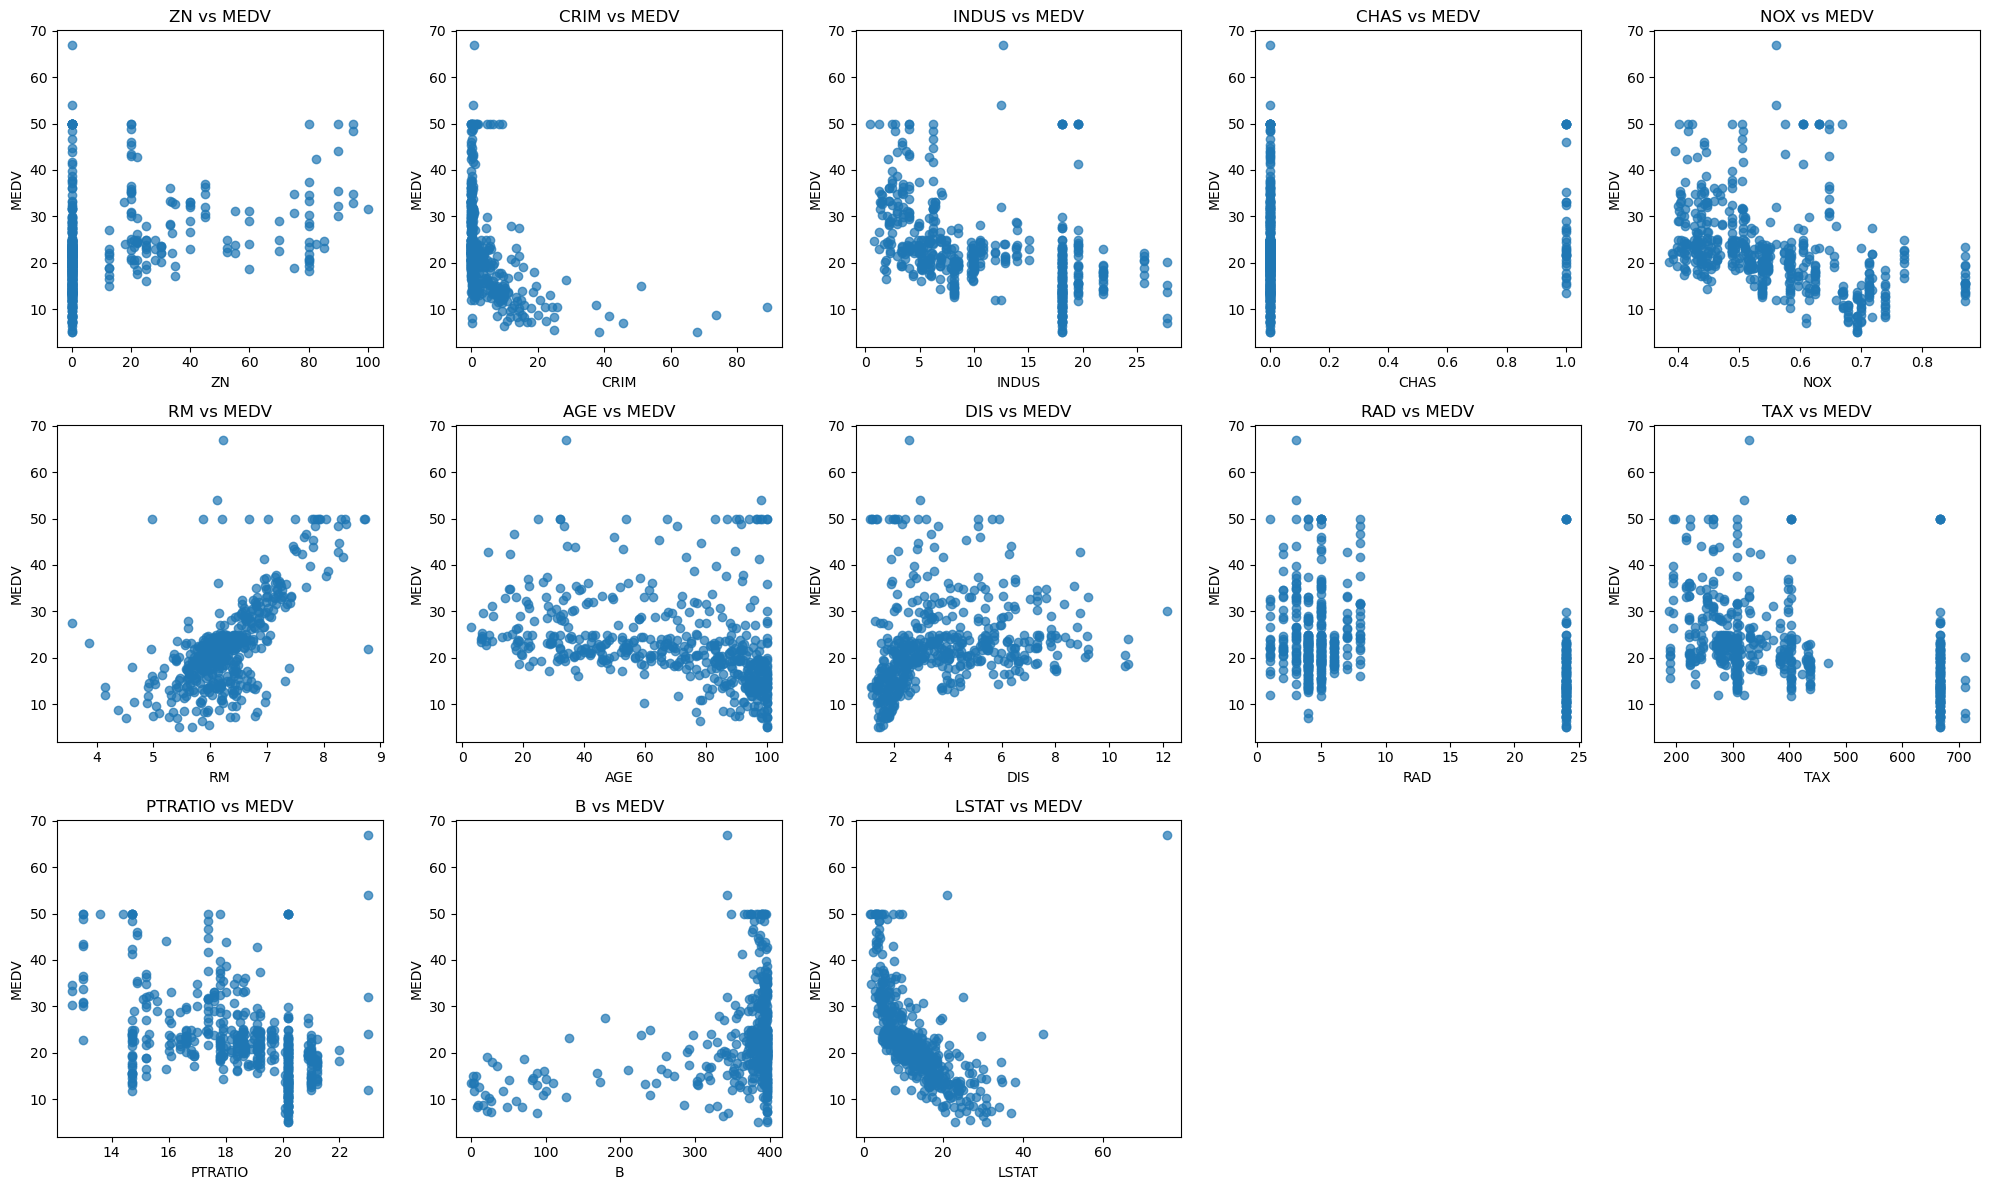

In [81]:
feature_candidates = ['ZN', 'CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

num_features = len(feature_candidates)
num_rows = 3
num_cols = (num_features + num_rows - 1) // num_rows

plt.figure(figsize=(num_cols * 4, num_rows * 4))

for i, feature in enumerate(feature_candidates):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(data[feature], data['MEDV'], alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('MEDV')
    plt.title(f'{feature} vs MEDV')
    plt.gca()  # Make plots square

plt.tight_layout()
plt.show()


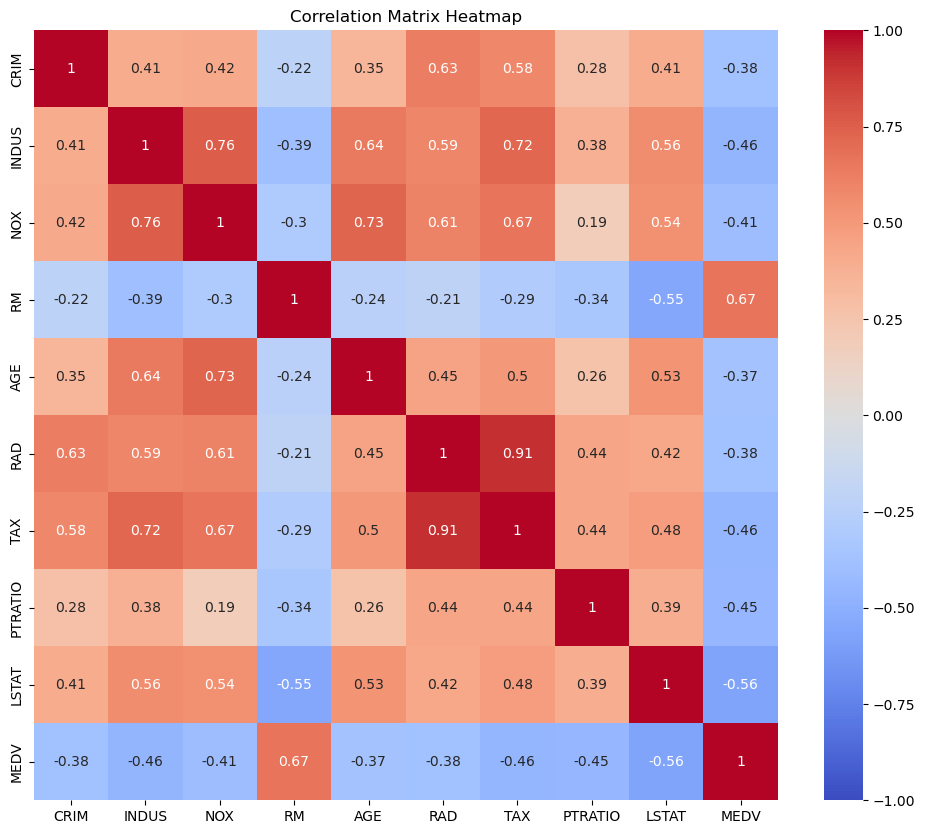

In [95]:
corr_matrix = data.corr()
medv_corr = corr_matrix['MEDV']

# Filter out columns with correlation between -0.35 and 0.35 with 'MEDV'
columns_to_keep = medv_corr[~medv_corr.abs().between(-0.35, 0.35)].index
filtered_data = data[columns_to_keep]

filtered_corr_matrix = filtered_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()